# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Мы будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


**Описание данных**
```
Технологический процесс

Rougher feed — исходное сырье
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
Xanthate **— ксантогенат (промотер, или активатор флотации);
Sulphate — сульфат (на данном производстве сульфид натрия);
Depressant — депрессант (силикат натрия).
Rougher process (англ. «грубый процесс») — флотация
Rougher tails — отвальные хвосты
Float banks — флотационная установка
Cleaner process — очистка
Rougher Au — черновой концентрат золота
Final Au — финальный концентрат золота
Параметры этапов
air amount — объём воздуха
fluid levels — уровень жидкости
feed size — размер гранул сырья
feed rate — скорость подачи
```
**Наименование признаков**
```
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
rougher — флотация
primary_cleaner — первичная очистка
secondary_cleaner — вторичная очистка
final — финальные характеристики
Возможные значения для блока [тип_параметра]:
input — параметры сырья
output — параметры продукта
state — параметры, характеризующие текущее состояние этапа
calculation — расчётные характеристики

```

## Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

### Откроем файлы и изучим их

Загрузим базы данных:

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Изучим с помощью метода `info`:

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [5]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


И еще ознакомимся с первыми рядами таблицы `data_train`:

In [6]:
pd.options.display.max_rows = None
data_train[:4].transpose()

,0,1,2,3
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819
final.output.recovery,70.541216,69.266198,68.116445,68.347543
final.output.tail_ag,10.411962,10.462676,10.507046,10.422762
final.output.tail_pb,0.895447,0.927452,0.953716,0.883763
final.output.tail_sol,16.904297,16.634514,16.208849,16.532835
final.output.tail_au,2.143149,2.22493,2.257889,2.146849


Метод `info` подсказал, что в выборках есть пропуски, посчитает их:

In [7]:
print('Пропуски в обучающей выборке: \n', data_train.isna().sum().loc[data_train.isna().sum()>0],'\n', sep="")
print('Пропуски в тестовой выборке: \n', data_test.isna().sum().loc[data_test.isna().sum()>0],'\n', sep="")
print('Пропуски в исходной выборке: \n', data_full.isna().sum().loc[data_full.isna().sum()>0],'\n', sep="")

Пропуски в обучающей выборке: 
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.tail_pb                                   100
final.output.tail_sol                                    5
primary_cleaner.input.sulfate                           20
primary_cleaner.input.depressant                        32
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 286
primary_cleaner.output.tail_ag                           1
primary_cleaner.output.tail_pb                          15
primary_cleaner.output.tail_sol                         46
primary_cleaner.state.floatbank8_a_air                   4
primary_cleaner.state.floatbank8_a_level                 1
primary_cleaner.state.floatbank8_b_air                   4
primary_cleaner.state.flo

Пропусков довольно много, чуть позже уберем их.

Проверим на дубликаты:

In [8]:
display(data_train.duplicated().sum(), data_test.duplicated().sum(), data_full.duplicated().sum())

0

0

0

Дубликатов нет.

У нас есть три выборки, одна из которых частично состоих из двух других. В них нет дубликатов, есть пропуски. В общей выборке 19439 строк, в учебной - 14149, в тестовой - 5290.

### Проверим правильность рассчета эффективностио богащения

В целях проекта проверить корректность рассчета эффективности обогащения `recovery`.

Сначала найдем все колонки связанные с золотом, чтобы было проще подобрать значения для формулы:

In [9]:
data_train_au = data_train.filter(regex='au')
data_train_au[:4].transpose()

,0,1,2,3
final.output.concentrate_au,42.192020,42.701629,42.657501,42.689819
final.output.tail_au,2.143149,2.224930,2.257889,2.146849
primary_cleaner.output.concentrate_au,34.174427,34.118526,33.969464,28.260743
primary_cleaner.output.tail_au,2.106679,2.353017,2.416800,2.262051
rougher.calculation.sulfate_to_au_concentrate,41885.707031,42050.861809,42018.101184,42029.447991
rougher.calculation.floatbank10_sulfate_to_au_feed,3481.779053,3498.370979,3495.348910,3498.578313
rougher.calculation.floatbank11_sulfate_to_au_feed,3520.337158,3489.981857,3502.359819,3499.162912
rougher.calculation.au_pb_ratio,2.838687,2.858998,2.945989,3.002340
rougher.input.feed_au,6.486150,6.478583,6.362222,6.118189
rougher.output.concentrate_au,19.793808,20.050975,19.737170,19.320810


Формула для рассчета эффективности:

![recovery](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg "recovery")
```
где:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

```

Ввведем переменные из датасета и посчитаем по формуле эффективность:

In [10]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T =  data_train['rougher.output.tail_au']

rougher_output_recovery_calculated = (C * (F - T)) / (F * (C - T)) * 100

Посчитаем MAE для эффективности очистки расчетной и фактической:

In [11]:
print('Среднее абсолютное отклонение для признака эффективности очистки после флотации:'
      , mean_absolute_error(rougher_output_recovery_calculated, data_train['rougher.output.recovery']))

Среднее абсолютное отклонение для признака эффективности очистки после флотации: 9.73512347450521e-15


Значение MAE ничтожно мало, что означает, что значения эффективности в датасете рассчитаны корректно.

### Проанализируем признаки, недоступные в тестовой выборке

Найдем признаки отсутствующие в тестовой выборке:

In [12]:
different_cols = data_full.columns.difference(data_test.columns)
different_cols.to_list()

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Столбцы, которые отсутствуют в тестовой выборке в своем значении на втором месте, включают слово `output`, обозначающий целевые признаки с параметрами готового продукта после различных стадий, а также признак `calculation`, который рассчитывается на основании этих параметров. Таким образом, можно заключить, что в тестовой выборке отсутствуют данные, полученные после каждой стадии обработки. Запомним эти столбцы, как целевые, они пригодятся нам в дальнейшем.


### Проведем предобработку данных

Нужно разабраться с пропусками в данных. Запомним пропуски используя возможности `fillna` с методом `ffill`:

In [14]:
data_train = data_train.fillna(method='ffill')

data_full = data_full.fillna(method='ffill')

data_test = data_test.fillna(method='ffill')

Предобработка данных завершена:

- Мы открылы и изучили данные: установили отсутствие дубликатов и заполнили пропуски
- Проверили данные на корректность, в частности, что эффективность обогащения соответствует расчетной
- Установили какие целевые признаки отсутствуют в тестовой выборке, выделили их в отдельную переменную

## Анализ данных

### Изменение концентрации металлов на различных этапах очистки

Изучим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки:

Сделаем три отдельные выборки для каждого металла:

In [15]:
data_ag_conc = data_full.filter(regex='(concentrate_ag|feed_ag)')
data_ag_conc.columns = data_ag_conc.columns.str.rstrip('_ag')
data_pb_conc = data_full.filter(regex='(concentrate_pb|feed_pb)')
data_pb_conc.columns = data_pb_conc.columns.str.rstrip('_pb')
data_au_conc = data_full.filter(regex='(concentrate_au|feed_au)')
data_au_conc.columns = data_au_conc.columns.str.rstrip('_au')

Создадим функцию, чтобы переименовать колонки и привести данные к общему виду:

In [16]:
pd.set_option('mode.chained_assignment', None)

def rename_func(table):
    table.rename(columns={'rougher.input.feed': '01 Начальная концентрация', 
                          'rougher.output.concentrate': '02 Концентрация после флотации', 
                          'primary_cleaner.output.concentrate': '03 Концентрация после очистки', 
                          'final.output.concentrate': '04 Финальная концентрация'}, inplace=True)
    table.sort_index(axis=1, inplace=True)
    
    return table

for m in (data_ag_conc, data_pb_conc, data_au_conc):
    rename_func(m)

Создадим функцию, которая нарисует график для каждой выборки:

In [17]:
def conc_func(table1, metal):
    plt.figure(figsize=(15,7))
    graf = plt.hist(table1,
    bins=100,
    color=['red', 'orange', 'green','blue'],
    rwidth=0.85,                
    alpha=0.5);
    plt.grid(axis='y', alpha=0.7)
    plt.legend(table1, fontsize=15)
    plt.xlabel('Концентрация', fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.title('График распределение концентрации {} в зависимости от стадии обработки:'.format(metal), fontsize=15)
    print('Распределение концентрации {}  в зависимости от стадии обработки:'.format(metal))
    print('Среднее значение концентраций: \n', table1.mean(axis=0), sep='')

Теперь применим ее для каждого металла:

Распределение концентрации свинца  в зависимости от стадии обработки:
Среднее значение концентраций: 
01 Начальная концентрация         3.585096
02 Концентрация после флотации    7.606272
03 Концентрация после очистки     9.810317
04 Финальная концентрация         9.978821
dtype: float64


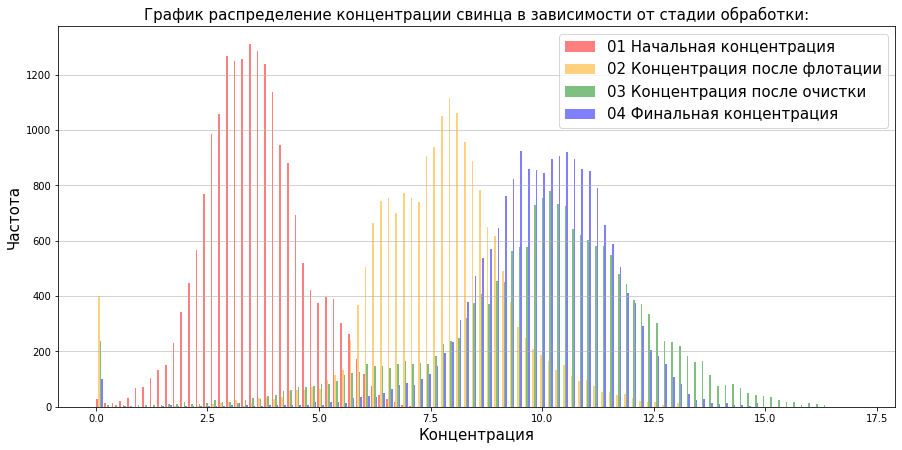

In [18]:
conc_func(data_pb_conc, 'свинца');

Распределение концентрации серебра  в зависимости от стадии обработки:
Среднее значение концентраций: 
01 Начальная концентрация          8.794927
02 Концентрация после флотации    11.994759
03 Концентрация после очистки      8.442408
04 Финальная концентрация          5.168387
dtype: float64


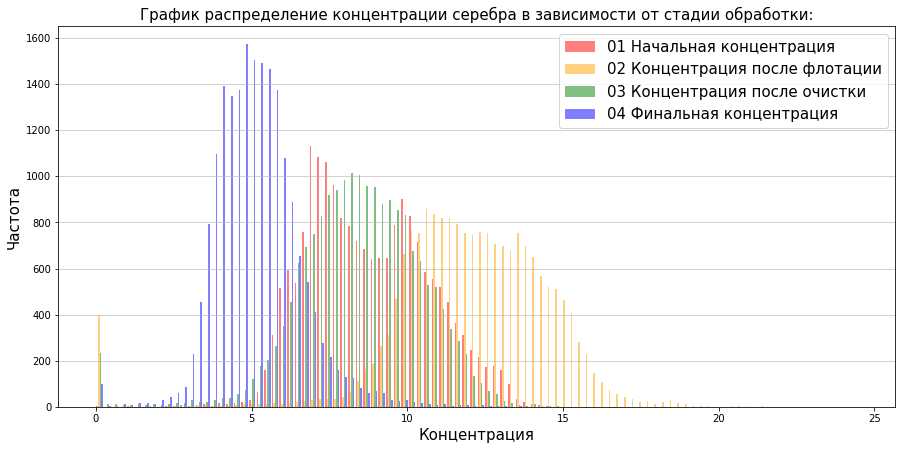

In [19]:
conc_func(data_ag_conc, 'серебра');

Распределение концентрации золота  в зависимости от стадии обработки:
Среднее значение концентраций: 
01 Начальная концентрация          8.266097
02 Концентрация после флотации    19.772000
03 Концентрация после очистки     32.119400
04 Финальная концентрация         44.076513
dtype: float64


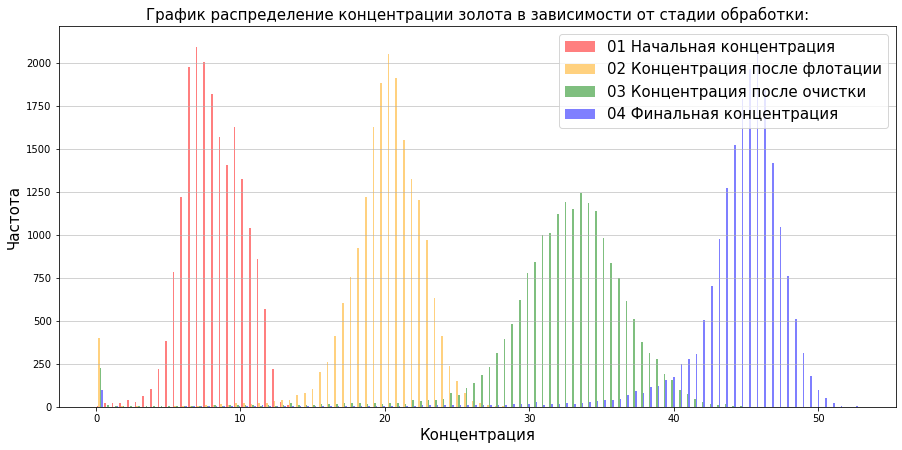

In [20]:
conc_func(data_au_conc, 'золота');

Дополнительно изучим изменение средних значений концентраций для каждого металла на каждом этапе очистки:

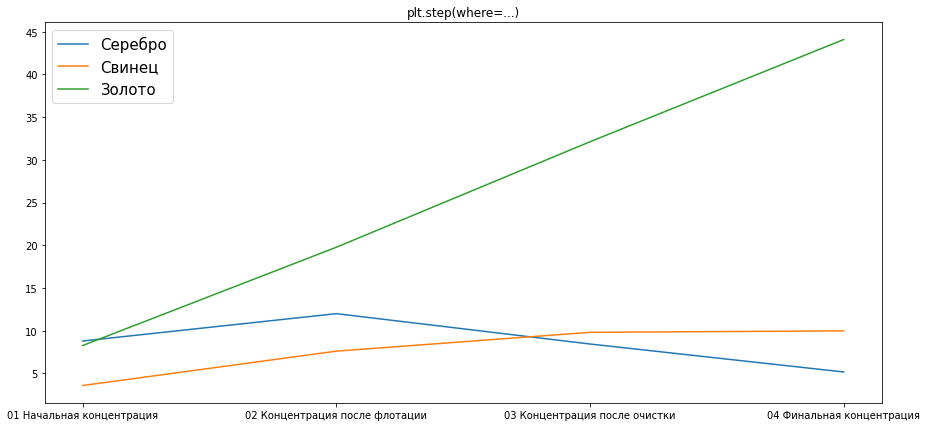

In [21]:
plt.figure(figsize=(15,7))
plt.plot(data_ag_conc.mean(), label='Серебро')
plt.plot(data_pb_conc.mean(), label='Свинец')
plt.plot(data_au_conc.mean(), label='Золото')
plt.legend(fontsize=15)
plt.title('plt.step(where=...)')
plt.show()

После расмотрения полученных графиков можно сказать, что после каждого этапа очистки растет концентрация золота `au` в сырье. Оно увеличивается с 8 до 44. Тоже растет концентрация, но слабее свинца `pb`, с 3 до 10. Содержание же серебра `ag` повышается с 10 до максимального 12 после процесса флотации, а потом падает до 5.

### Проанализируем распределения размеров гранул на обучающей и тестовой выборках

Теперь проведем анализ распределения размера гранул на обучающей и тестовых выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Для этого будем изучать колонки `rougher.input.feed_size` в обоих выборках:

In [22]:
data_feed_size_rougher = pd.concat([data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size']], axis=1)
data_feed_size_rougher.columns = ['Train Feed Size', 'Test Feed Size'] 

In [23]:
data_feed_size_cleaner = pd.concat([data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size']], axis=1)
data_feed_size_cleaner.columns = ['Train Feed Size', 'Test Feed Size']  

Изучать мы будем через гистограмму плотности.
Напишем функцию, для отображения графика:

In [24]:
def conc_distr(table2):
    plt.figure(figsize=(15,7))
    graf = plt.hist(table2,
    bins='auto',
    color=['green', 'red'],
    rwidth=0.85,                
    alpha=0.5,                
    density=True);
    plt.grid(axis='y', alpha=0.7)
    plt.legend(table2, fontsize=15)
    plt.xlabel('Концентрация', fontsize=15)
    plt.ylabel('Плотность', fontsize=15)
    plt.title('Распределение размера гранул в обучающей и тестовой выборках:', fontsize=15)

Распределение размера гранул при процессе флотации:


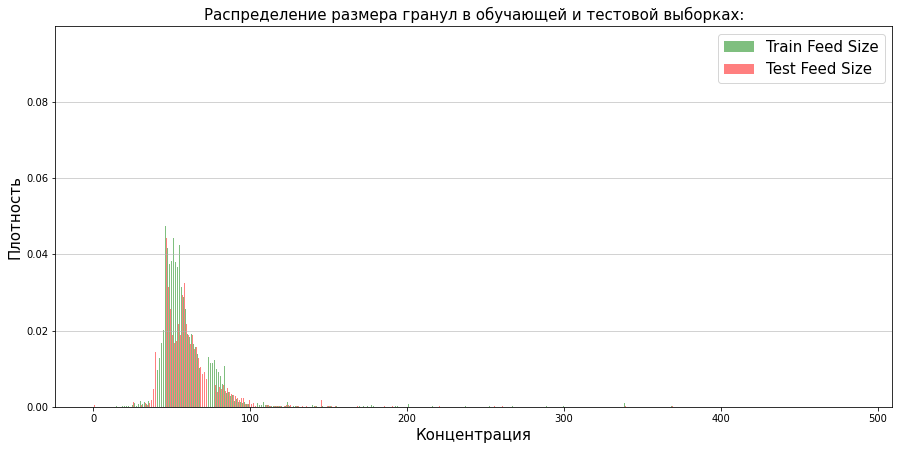

In [25]:
print('Распределение размера гранул при процессе флотации:')
conc_distr(data_feed_size_rougher)

Распределение размера гранул при процессе очистки:


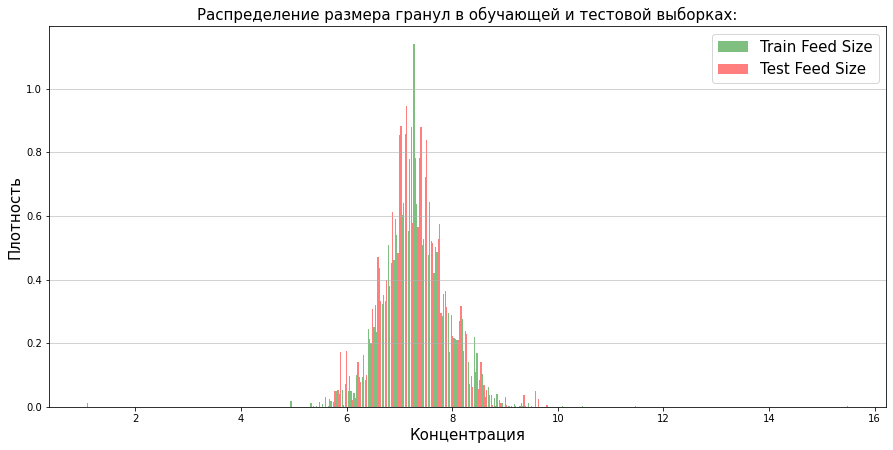

In [26]:
print('Распределение размера гранул при процессе очистки:')
conc_distr(data_feed_size_cleaner)

Как можно заметить на графиках распределения для размера гранул в обучающих и тестовых выборках как на стадии флотации так и на стадии очисти совпадает, значит на работу модели это не повлияет.


### Исследование суммарной концентрации всех веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
Выведем небольшую шпаргалку, чтобы выбрать правильные столбики:

In [27]:
data_сoncentrate_raw = data_full.filter(regex='(concentrate|feed)')
data_сoncentrate_raw[:4].transpose()

,0,1,2,3
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634
final.output.concentrate_au,42.192020,42.701629,42.657501,42.689819
primary_cleaner.input.feed_size,7.250000,7.250000,7.250000,7.250000
primary_cleaner.output.concentrate_ag,8.547551,8.558743,8.603505,7.221879
primary_cleaner.output.concentrate_pb,10.389648,10.497069,10.354494,8.496563
primary_cleaner.output.concentrate_sol,19.529297,19.369147,19.167579,15.978538
primary_cleaner.output.concentrate_au,34.174427,34.118526,33.969464,28.260743
rougher.calculation.sulfate_to_au_concentrate,41885.707031,42050.861809,42018.101184,42029.447991


Создадим отдельный датафрейм где сведем суммарную информацию о концинтрации веществ:

In [28]:
data_сoncentrate_full = pd.DataFrame()

data_сoncentrate_full['01 Концентрация в сырье'] = (data_full['rougher.input.feed_ag']
    + data_full['rougher.input.feed_pb']
    + data_full['rougher.input.feed_au']
    + data_full['rougher.input.feed_sol'])

data_сoncentrate_full['02 Концентрация в черновом'] = (data_full['rougher.output.concentrate_ag'] 
    + data_full['rougher.output.concentrate_pb']
    + data_full['rougher.output.concentrate_au']
    + data_full['rougher.output.concentrate_sol'])

data_сoncentrate_full['03 Финальная концентрация'] = (data_full['final.output.concentrate_ag'] 
    + data_full['final.output.concentrate_pb']
    + data_full['final.output.concentrate_au']
    + data_full['final.output.concentrate_sol'])

#data_сoncentrate_full[:4].transpose()

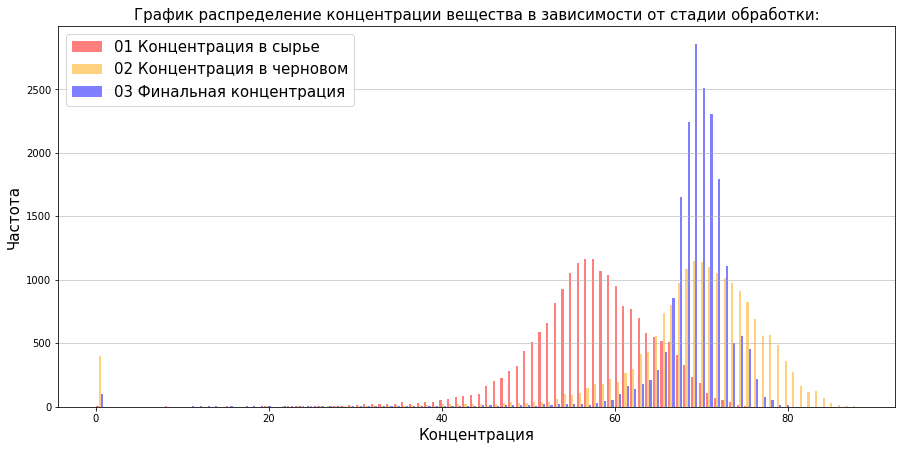

In [29]:
plt.figure(figsize=(15,7))

plt.hist(data_сoncentrate_full, bins=100, color=['red', 'orange', 'blue'], rwidth=0.85, alpha=0.5);

plt.grid(axis='y', alpha=0.7)
plt.legend(data_сoncentrate_full, fontsize=15)
plt.xlabel('Концентрация', fontsize=15)
plt.ylabel('Частота', fontsize=15)
plt.title('График распределение концентрации вещества в зависимости от стадии обработки:', fontsize=15);

По графику видно, как растет (сдвигается вправо) концентрация после черновой обработки по сравнению со стадией необработанного сырья: среднее в районе 70 против 60. Дальнейшая обработка держится на этом же уровне, только увеличивая частоту элементов с высокой концентрацией и поэтому пирамида финальной концентрации становится уже. Так же на этом графике заметно, что в данных существуют выбросы в районе 0 значений. Нужно их убрать:

In [30]:
for col in different_cols:
    data_train_clean = data_train[data_train[col]>0]

После проведенного анализа данных можно сделать следующие выводы:
- Установили, что каждый этап очистки увеличивает концентрацию золота, его концентрация увеличивается в 5 раз с 8 до 40 
- Мы подтвердили, что в учебной и тестовой выборках распределение размеров гранул совпадает и значит можно обучать и проверять модели
- Каждая стадия обработки влияет на концентрацию веществ, сначала увеличивая ее, а потом уменьша разброс

## Модель

### Напишем функцию для вычисления итоговой sMAPE

Прежде чем обучить модель необходимо создать функцию для расчета симметричного среднего абсолютного процентного отклонения( sMAPE): 

Формула для рассчета SMAPE:

![smape](https://pictures.s3.yandex.net/resources/smape_1576239058.jpg "smape")
![smape_final](https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg "smape_final")

Так как формула должна затрагивать сразу два показателя, то в теле общей функции мы создадим функцию сначала для `rougher`, затем для `final`, а после объединим в одну:

In [31]:
def smape(t, p):
    
    t = t.to_numpy()

    t_rougher = t[:, 0]
    p_rougher = p[:, 0]
    
    
    smape_rougher = np.mean(
            np.abs(p_rougher - t_rougher) / 
            ((np.abs(p_rougher) + np.abs(t_rougher))/2)
        )*100

    t_final = t[:, 1]
    p_final = p[:, 1]

    smape_final = np.mean(
            np.abs(p_final - t_final) / 
            ((np.abs(p_final) + np.abs(t_final))/2)
        )*100
    
    smape = smape_rougher * 0.25 + smape_final * 0.75
    
    return smape

Теперь с помощью `make_scorer` сделаем нашу функцию SMAPE пригодной к использованию при обучении модели:

In [32]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Подготовка выборок

Разделим данные на признаки и целевые признаки:

Тестовая выборка уже готова, чтобы быть `data_test_features`: 

In [33]:
data_test_features = data_test

Осталось сделать соответствующую выборку с целевыми признаками. Для этого выведем необходимые столбцы из `data_full` с помощью функции `merge`:

In [34]:
data_test_target = (
data_test[['date']].merge(data_full[['rougher.output.recovery','final.output.recovery', 'date']],
on='date', how='inner', copy='False')
)

Проверим корректность с помощью функции `shape`, чтобы совпадало количество строк:

In [35]:
display(data_test_target.shape, data_test_features.shape)

(5290, 3)

(5290, 53)

Теперь для дальнейшей работы разобьем обучающую выборку - исключим из нее целевые признаки и выделем в отдельный датасет. Удалим и колонку `date` так как она не понадобится для обучения модели:

In [36]:
data_train_features = data_train_clean.drop(different_cols.union(['date']), axis=1)
data_train_target = data_train_clean[['rougher.output.recovery','final.output.recovery']]

Удалим столбец `date` и из тестовой выборки:

In [37]:
data_test_features = data_test_features.drop('date', axis=1)
data_test_target = data_test_target.drop('date', axis=1)

Теперь масштабируем признаки в обучающей и тестовой выборках:

In [38]:
scaler = StandardScaler()
scaler.fit(data_train_features) 
data_train_features = scaler.transform(data_train_features)
data_test_features = scaler.transform(data_test_features)

### Обучим модели

Начнем изучение моделей с линейной регресси:

In [39]:
model = LinearRegression()
model.fit(data_train_features, data_train_target)
smape_mean = cross_val_score(model, data_train_features, data_train_target, cv=3, scoring=smape_scorer).mean()
print('Показатель SMAPE:', -smape_mean)

Показатель SMAPE: 13.84338261011988


Следующей проверим модель дерева решений:

In [40]:
param_grid = {'max_depth': range(1, 11)}

model = DecisionTreeRegressor(random_state=12345)
gsearch = GridSearchCV(model, param_grid, cv=3, scoring=smape_scorer, n_jobs=-1, verbose=10)
gsearch.fit(data_train_features, data_train_target)
print(' Лучший показатель SMAPE:', -gsearch.best_score_,'\n При максимальной глубине:', gsearch.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START max_depth=1................................................
[CV 1/3; 1/10] END ..............................max_depth=1; total time=   0.1s
[CV 2/3; 1/10] START max_depth=1................................................
[CV 2/3; 1/10] END ..............................max_depth=1; total time=   0.1s
[CV 3/3; 1/10] START max_depth=1................................................
[CV 3/3; 1/10] END ..............................max_depth=1; total time=   0.1s
[CV 1/3; 2/10] START max_depth=2................................................
[CV 1/3; 2/10] END ..............................max_depth=2; total time=   0.1s
[CV 2/3; 2/10] START max_depth=2................................................
[CV 2/3; 2/10] END ..............................max_depth=2; total time=   0.1s
[CV 3/3; 2/10] START max_depth=2................................................
[CV 3/3; 2/10] END .............................

/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 3/3; 5/10] END ..............................max_depth=5; total time=   0.2s
[CV 1/3; 6/10] START max_depth=6................................................
[CV 1/3; 6/10] END ..............................max_depth=6; total time=   0.3s
[CV 2/3; 6/10] START max_depth=6................................................
[CV 2/3; 6/10] END ..............................max_depth=6; total time=   0.3s
[CV 3/3; 6/10] START max_depth=6................................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 3/3; 6/10] END ..............................max_depth=6; total time=   0.3s
[CV 1/3; 7/10] START max_depth=7................................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 1/3; 7/10] END ..............................max_depth=7; total time=   0.3s
[CV 2/3; 7/10] START max_depth=7................................................
[CV 2/3; 7/10] END ..............................max_depth=7; total time=   0.3s
[CV 3/3; 7/10] START max_depth=7................................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 3/3; 7/10] END ..............................max_depth=7; total time=   0.3s
[CV 1/3; 8/10] START max_depth=8................................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 1/3; 8/10] END ..............................max_depth=8; total time=   0.4s
[CV 2/3; 8/10] START max_depth=8................................................


/tmp/ipykernel_1228/894555044.py:18: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_final - t_final) /


[CV 2/3; 8/10] END ..............................max_depth=8; total time=   0.4s
[CV 3/3; 8/10] START max_depth=8................................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 3/3; 8/10] END ..............................max_depth=8; total time=   0.4s
[CV 1/3; 9/10] START max_depth=9................................................
[CV 1/3; 9/10] END ..............................max_depth=9; total time=   0.4s
[CV 2/3; 9/10] START max_depth=9................................................


/tmp/ipykernel_1228/894555044.py:18: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_final - t_final) /


[CV 2/3; 9/10] END ..............................max_depth=9; total time=   0.4s
[CV 3/3; 9/10] START max_depth=9................................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /


[CV 3/3; 9/10] END ..............................max_depth=9; total time=   0.5s
[CV 1/3; 10/10] START max_depth=10..............................................
[CV 1/3; 10/10] END ............................max_depth=10; total time=   0.4s
[CV 2/3; 10/10] START max_depth=10..............................................
[CV 2/3; 10/10] END ............................max_depth=10; total time=   0.4s
[CV 3/3; 10/10] START max_depth=10..............................................


/tmp/ipykernel_1228/894555044.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.abs(p_rougher - t_rougher) /
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-11.89601842 -11.79278576 -12.28090621 -11.69444809          nan
          nan          nan          nan          nan          nan]
  warnings.warn(


[CV 3/3; 10/10] END ............................max_depth=10; total time=   0.4s
 Лучший показатель SMAPE: 11.694448094777464 
 При максимальной глубине: {'max_depth': 4}


И последней оценим модель случайного леса:

In [41]:
param_grid = {'n_estimators': range(96, 97), 'max_depth': range(3,6)}

model = RandomForestRegressor(random_state=12345, n_estimators = 96)
gsearch = GridSearchCV(model, param_grid, cv=3, scoring=smape_scorer, n_jobs=-1, verbose=10)
gsearch.fit(data_train_features, data_train_target)
print(' Лучший показатель SMAPE:', -gsearch.best_score_
      ,'\n При глубине и количестве деревьев:', gsearch.best_params_)

# , max_depth = 2 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3; 1/3] START max_depth=3, n_estimators=96................................
[CV 1/3; 1/3] END ..............max_depth=3, n_estimators=96; total time=   9.0s
[CV 2/3; 1/3] START max_depth=3, n_estimators=96................................
[CV 2/3; 1/3] END ..............max_depth=3, n_estimators=96; total time=   8.8s
[CV 3/3; 1/3] START max_depth=3, n_estimators=96................................
[CV 3/3; 1/3] END ..............max_depth=3, n_estimators=96; total time=   8.9s
[CV 1/3; 2/3] START max_depth=4, n_estimators=96................................
[CV 1/3; 2/3] END ..............max_depth=4, n_estimators=96; total time=  11.7s
[CV 2/3; 2/3] START max_depth=4, n_estimators=96................................
[CV 2/3; 2/3] END ..............max_depth=4, n_estimators=96; total time=  11.3s
[CV 3/3; 2/3] START max_depth=4, n_estimators=96................................
[CV 3/3; 2/3] END ..............max_depth=4, n_est

После обучения и настройки различных моделей мы можем сказать, что лучше всего с результатом SMAPE в 9,07 себя показала **модель случайного леса с параметрами: максимальная глубина = 5, количество деревьев = 96**.

### Проверка качества модели на тестовой выборке

Теперь проверим лучшую модель на тестовой выборке. Снова зададим ей подходящие параметры и обучим ее на учебной выборке, а затем проверим на тестовой:

In [42]:
best_model = RandomForestRegressor(max_depth=5, n_estimators = 96, random_state=12345)
best_model.fit(data_train_features, data_train_target)
prediction = best_model.predict(data_test_features)

print('Показатель SMAPE на тестовой выборке:', smape(data_test_target, prediction))

Показатель SMAPE на тестовой выборке: 9.45291224075223


**Показатель SMAPE оказался лучше, чем был на учебной и равен 9,45. Можно уверенно сказать, что модель нам подходит**.

Теперь осталось проверить нашу модель на адекватность:

In [43]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(data_train_features, data_train_target)
dummy_prediction = dummy_model.predict(data_test_features)
smape(data_test_target, dummy_prediction)

10.334160970246636

Предсказание dummy-модели хуже, а значит, что наша модель прошла проверку на адекватность.

**Итог проекта:**

- После подготовки и предобработки данных мы обучили подходящую модель для предсказания конентрации золота: это модель случайного леса (RandomForestRegressor), ее гиперпараметры: глубина 4, количество деревьев 96.

- Показатели метрики SMAPE для этой модели при кросс-валидацинной проверке на учебной выборке составил: 11.10

- Показатели метрики SMAPE для этой модели при проверке на тестовой выборке составил: 9.45

- Модель прошла проверку на адекватность, для dummy-модели метрика SMAPE равна: 10.33

- Модель показала хороший результат и может использоваться в дальнейшем